# Preprocessing the dataset

First we will preform all the necessary imports

In [108]:
import numpy as np
import pandas as pd
import re
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

We then load the test and training dataset

In [109]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

We then proceed to store all the passengers numbers for easy access and print out the first three values in the traning dataset to get a look at how it looks

In [110]:
Passengers_id = test_df['PassengerId']
train_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


# Preprocessing

We will store a copy of the original training dataset as we are about to do some edits to it, and we will need the original one for finding out features later

In [111]:
original_train_df=train_df.copy()
complete_data=[test_df,train_df]

We then create three new features, has_cabin which tells if a person has cabin or not, family_size which adds number of siblings and number of parents on board, and finally is_alone to see if the person is travelling alone or not.

In [112]:
train_df['Has_Cabin'] = train_df["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test_df['Has_Cabin'] = test_df["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
for dataset in complete_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
for dataset in complete_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
for dataset in complete_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
for dataset in complete_data:
    dataset['Fare'] = dataset['Fare'].fillna(train_df['Fare'].median())

We then proceed to fill in the null values in all age columns.

In [113]:
for dataset in complete_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

We then extract all the title per passangers if they have any

In [114]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

for dataset in complete_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
for dataset in complete_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

Now we create a mapping for the features title, sex, age, fare, and embarked.

In [115]:
for dataset in complete_data:
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] ;
        
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

Now we drop the features which we classify as no longer useful

In [116]:
train_df = train_df.drop(['Cabin', 'Ticket' , 'Name', 'SibSp', 'PassengerId'], axis = 1)
test_df  = test_df.drop(['Cabin', 'Ticket' , 'Name', 'SibSp', 'PassengerId'], axis = 1)

We now again visualize how the data looks as it will have only useful values and potentially useful features

In [117]:
train_df.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,0,2,0,1
1,1,1,0,2,0,3,1,1,2,0,3
2,1,3,0,1,0,1,0,0,1,1,4


We can now proceed to find the relation between our current variables using Pearson Correlation graph

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

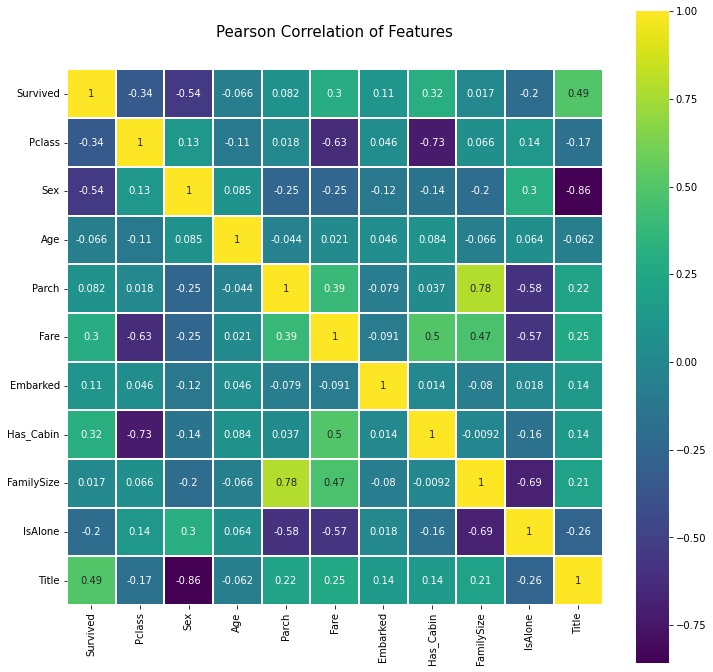

In [118]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_df.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

From this we can observe two features having the highest absolute values correlation with survived, which are:
    1. Sex with 0.54
    2. Title with 0.49
But we can see those two have very high correlation between them as well 0.86 due to which we cannot use both of them in our first kernal split so we will have to investigate further these two features

We can easily find relationships between groups of classes by comparing a few features between them.

In [119]:
train_df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).agg(['mean', 'count', 'sum'])

Survived           
         mean count  sum
Sex                     
0    0.742038   314  233
1    0.188908   577  109

In [120]:
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])

Survived           
           mean count  sum
Title                     
1      0.156673   517   81
2      0.575000    40   23
3      0.793651   126  100
4      0.702703   185  130
5      0.347826    23    8

By this we can see that lesser number of people with the title "Mr." survived than just men in general. So using title gives more clarity than using sex, upon that we can also claim that using title also gives us info about the persons sex. We can verify the last statment by using the original df we kept away and see what is the mean between number of male and female given a title.

In [121]:
title_and_sex = original_train_df.copy()[['Name', 'Sex']]
title_and_sex['Title'] = title_and_sex['Name'].apply(get_title)
title_and_sex['Sex'] = title_and_sex['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
title_and_sex[['Title', 'Sex']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])

Sex           
              mean count  sum
Title                        
Capt      1.000000     1    1
Col       1.000000     2    2
Countess  0.000000     1    0
Don       1.000000     1    1
Dr        0.857143     7    6
Jonkheer  1.000000     1    1
Lady      0.000000     1    0
Major     1.000000     2    2
Master    1.000000    40   40
Miss      0.000000   182    0
Mlle      0.000000     2    0
Mme       0.000000     1    0
Mr        1.000000   517  517
Mrs       0.000000   125    0
Ms        0.000000     1    0
Rev       1.000000     6    6
Sir       1.000000     1    1

Above we can see except Dr, all others title have only females or males. So we can go ahead with using title as the first reference for our decision tree.

Now let us calculate the gini impurity to see which split can we use in out tree.

In [122]:
def get_gini_impurity(survived_count, total_count):
    survival_prob = survived_count/total_count
    not_survival_prob = (1 - survival_prob)
    random_observation_survived_prob = survival_prob
    random_observation_not_survived_prob = (1 - random_observation_survived_prob)
    mislabelling_survided_prob = not_survival_prob * random_observation_survived_prob
    mislabelling_not_survided_prob = survival_prob * random_observation_not_survived_prob
    gini_impurity = mislabelling_survided_prob + mislabelling_not_survided_prob
    return gini_impurity

Using the examples of sex and titles we can see what the impurity value of each split gives.

First we calculate for the root node, i.e for the 891 observations of which 342 survived.

Now we start the split by sex.

In [123]:
gini_impurity_starting_node = get_gini_impurity(342, 891)
gini_impurity_starting_node

0.47301295786144265

In [124]:
gini_impurity_men = get_gini_impurity(109, 577)
gini_impurity_men

0.3064437162277843

In [125]:
gini_impurity_women = get_gini_impurity(233, 314)
gini_impurity_women

0.3828350034484158

We can observe that gini impurity decreases if we split it by sex

In [126]:
men_weight = 577/891
women_weight = 314/891
weighted_gini_impurity_sex_split = (gini_impurity_men * men_weight) + (gini_impurity_women * women_weight)

sex_gini_decrease = weighted_gini_impurity_sex_split - gini_impurity_starting_node
sex_gini_decrease

-0.13964795747285214

Now we start the split by title

In [127]:
gini_impurity_title_1 = get_gini_impurity(81, 517)
gini_impurity_title_1

0.26425329886377663

In [128]:
gini_impurity_title_others = get_gini_impurity(261, 374)
gini_impurity_title_others

0.42170207898424317

In [129]:
title_1_weight = 517/891
title_others_weight = 374/891
weighted_gini_impurity_title_split = (gini_impurity_title_1 * title_1_weight) + (gini_impurity_title_others * title_others_weight)

title_gini_decrease = weighted_gini_impurity_title_split - gini_impurity_starting_node
title_gini_decrease

-0.14267004758907514

Gini impurity decreases if we split by title=1 which is "Mr."

# Finding best tree depth using 5 Fold Cross Validation

In [130]:
cv = KFold(n_splits=5)
list_of_accuracies = list()
max_attributes = len(list(test_df))
depth_range = range(1, max_attributes + 1)
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(max_depth = depth)
    for train_fold, valid_fold in cv.split(train_df):
        f_train = train_df.loc[train_fold]
        f_valid = train_df.loc[valid_fold]
        model = tree_model.fit(X = f_train.drop(['Survived'], axis=1),y = f_train["Survived"])
        valid_acc = model.score(X = f_valid.drop(['Survived'], axis=1),y = f_valid["Survived"])
        fold_accuracy.append(valid_acc)
    avg = sum(fold_accuracy)/len(fold_accuracy)
    list_of_accuracies.append(avg)
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": list_of_accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.778909
         2          0.787898
         3          0.822635
         4          0.826006
         5          0.817036
         6          0.804727
         7          0.804708
         8          0.810338
         9          0.802486
        10          0.806974


Here we can see that having the max depth of 3 gives us the best average accuracy, knowing this we can now make splits, train and test the Decision tree and also plot its structure.

In [134]:
import os
y_train = train_df['Survived']
x_train = train_df.drop(['Survived'], axis=1).values 
x_test = test_df.values

decisiontree_model = tree.DecisionTreeClassifier(max_depth = 3)
decisiontree_model.fit(x_train, y_train)

y_pred = decisiontree_model.predict(x_test)

with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(decisiontree_model,
                              out_file=f,
                              max_depth = 3,
                              impurity = True,
                              feature_names = list(train_df.drop(['Survived'], axis=1)),
                              class_names = ['Died', 'Survived'],
                              rounded = True,
                              filled= True )

Using an online converter i converted the dot file extension tree1 to .png and now lets view it

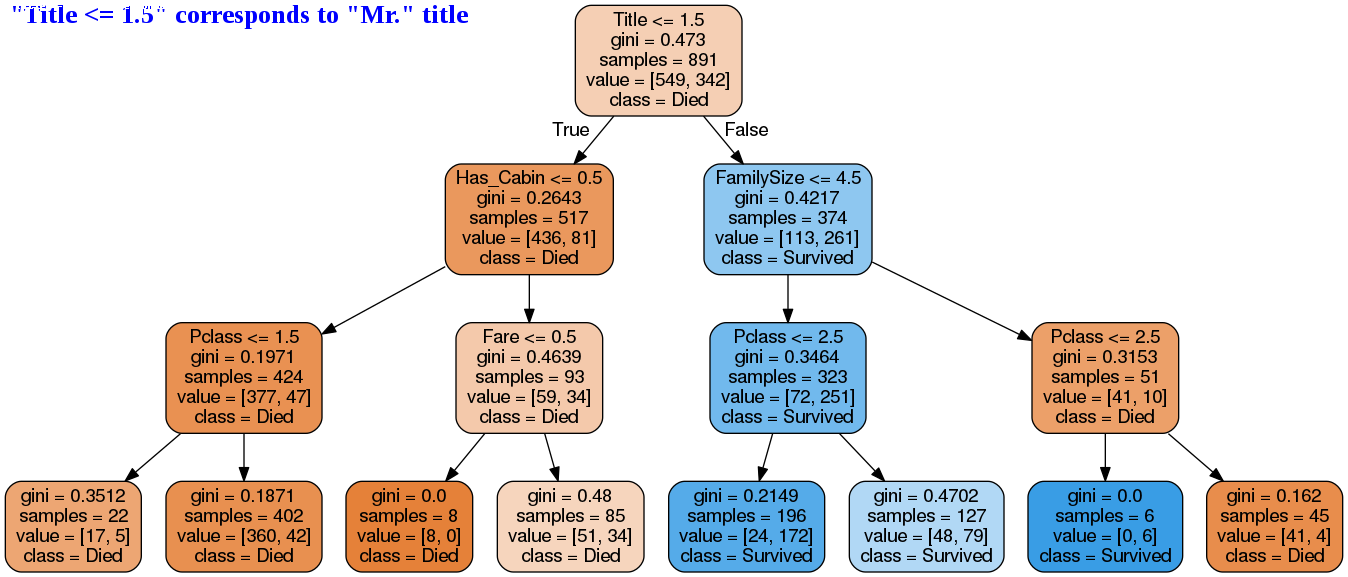

In [141]:
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
draw.text((10, 0), '"Title <= 1.5" corresponds to "Mr." title')
img.save('sample-out.png')
PImage("sample-out.png")